<a href="https://colab.research.google.com/github/Vanderval31bs/metricas-desempenho-dio/blob/main/calculo_metricas_avaliacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will build functions that compute the main validation metrics in machine learning, which are the accuracy, precision, recall, sensitivity, specificity and f1-score.

First, we train a simple model on the MNIST dataset, to have some result on which we will compute our data.

In [2]:
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import tensorflow as tf

import numpy as np

import seaborn as sns

import pandas as pd

In [3]:
%load_ext tensorboard

In [4]:
logdir='log'

In [5]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [6]:
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

train_images, test_images = train_images/255.0, test_images/255.0

classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [7]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation="relu",  input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

In [8]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [9]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(x=train_images, y=train_labels, epochs=5, validation_data=(test_images, test_labels))

Epoch 1/5
1875/1875 [==============================] - 77s 40ms/step - loss: 0.1348 - accuracy: 0.9578 - val_loss: 0.0441 - val_accuracy: 0.9854
Epoch 2/5
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0453 - accuracy: 0.9857 - val_loss: 0.0357 - val_accuracy: 0.9887
Epoch 3/5
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0319 - accuracy: 0.9898 - val_loss: 0.0362 - val_accuracy: 0.9893
Epoch 4/5
1875/1875 [==============================] - 54s 29ms/step - loss: 0.0248 - accuracy: 0.9922 - val_loss: 0.0259 - val_accuracy: 0.9910
Epoch 5/5
1875/1875 [==============================] - 55s 29ms/step - loss: 0.0187 - accuracy: 0.9944 - val_loss: 0.0240 - val_accuracy: 0.9926


In [10]:
y_true=test_labels

y_pred_prob=model.predict(test_images)
y_pred=np.argmax(y_pred_prob,axis=1)

313/313 [==============================] - 3s 8ms/step


Now, we are going to plot the confusion matrix that we got by applying the model on the test set

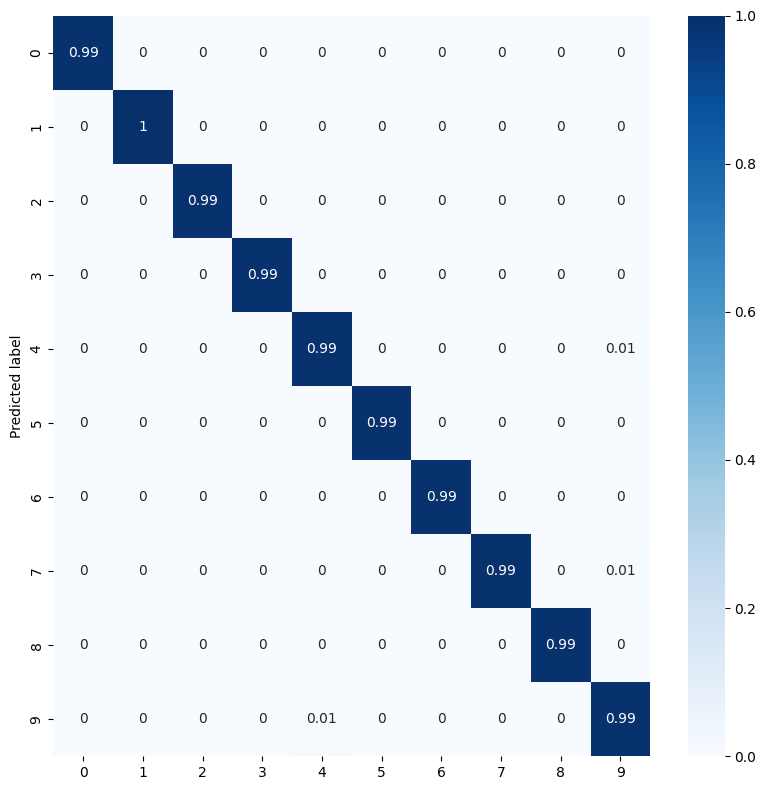

In [11]:
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm, index = classes, columns = classes)

figure = plt.figure(figsize=(8,8))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel("True label")
plt.ylabel("Predicted label")
plt.show()

Lets construct the validation metrics functions. The problem of MNIST is a multiclassification problem, so the validation metrics are going to be taken with respect to a specific label, which are called 'index' in the below functions. Also, we pass the confusion matrix in the argument of the functions.

We will first construct some help function that return the following quantities:


*   vp - true positive;
*   fp - false positive;
*   fn - false negative;
*   vn - true negative;
*   N - total number of elements.

In [12]:
def get_vp(matrix, index):
  return matrix[index][index]

def get_fp(matrix, index):
  col_sum = matrix[:, index].sum()
  return col_sum - get_vp(matrix,  index)

def get_fn(matrix, index):
  row_sum = matrix[index].sum()
  return row_sum - get_vp(matrix,  index)

def get_N(matrix):
  return matrix.sum();

def get_vn(matrix, index):
  matrix_sum = matrix.sum()
  return get_N(matrix) - get_fn(matrix, index) - get_fp(matrix, index) - get_vp(matrix, index)

Now, we define the functions that compute the validation metrics. The formulas of the metrics are given by:

$S := \text{Sensitivity} = \frac{vp}{vp + fn}$

$Sp := \text{Specificity} = \frac{vn}{fp + vn}$

$Ac := \text{Accuracy} = \frac{vp + vn}{N}$

$P := \text{Precision} = \frac{vp}{vp + fp}$

$Fs := \text{F-score} = 2 \cdot \frac{P \cdot S}{P + S}$

In [13]:
def get_sensibilidade(matrix, index):
  return get_vp(matrix, index) / (get_vp(matrix, index) + get_fn(matrix, index))

def get_especificidade(matrix, index):
  return get_vn(matrix, index) / (get_fp(matrix, index) + get_vn(matrix, index))

def get_accuracy(matrix, index):
  return (get_vp(matrix, index) + get_vn(matrix, index))/get_N(matrix)

def get_precision(matrix, index):
  return get_vp(matrix, index)/(get_vp(matrix, index) + get_fp(matrix, index))

def get_f_score(matrix, index):
  p = get_precision(matrix, index)
  s = get_sensibilidade(matrix, index)
  return 2 * (p * s) / (p + s)

Lets see some results for the digits 0 and 1:

In [14]:
print("get_sensibilidade 0: ", get_sensibilidade(con_mat, 0))
print("get_especificidade 0: ", get_especificidade(con_mat, 0))
print("get_accuracy 0: ", get_sensibilidade(con_mat, 0))
print("get_precision 0: ", get_precision(con_mat, 0))
print("get_f_score 0: ", get_f_score(con_mat, 0))

print("--------------------------------------------------")

print("get_sensibilidade 1: ", get_sensibilidade(con_mat, 1))
print("get_especificidade 1: ", get_especificidade(con_mat, 1))
print("get_accuracy 1: ", get_sensibilidade(con_mat, 1))
print("get_precision 1: ", get_precision(con_mat, 1))
print("get_f_score 1: ", get_f_score(con_mat, 1))

get_sensibilidade 0:  0.9938775510204082
get_especificidade 0:  0.9995565410199556
get_accuracy 0:  0.9938775510204082
get_precision 0:  0.9959100204498977
get_f_score 0:  0.9948927477017365
--------------------------------------------------
get_sensibilidade 1:  1.0
get_especificidade 1:  0.9986463620981387
get_accuracy 1:  1.0
get_precision 1:  0.9895379250217959
get_f_score 1:  0.9947414548641542


Now, instead of computing the metrics for each label, we compute the mean of the metrics for all lales, with the help of the following function:

In [15]:
def get_metrica_media(matrix, get_metrica):
  n = matrix.shape[0]
  sum = 0
  print("n", n)
  for i in range (n):
    sum = sum + get_metrica(matrix, i)
  return sum/n

Lets see the results:

In [17]:
print ("sensibilidade media", get_metrica_media(con_mat, get_sensibilidade))
print ("especificidade media", get_metrica_media(con_mat, get_especificidade))
print ("accuracy media", get_metrica_media(con_mat, get_accuracy))
print ("precision media", get_metrica_media(con_mat, get_precision))
print ("f-score media", get_metrica_media(con_mat, get_f_score))

n 10
sensibilidade media 0.9924963635720812
n 10
especificidade media 0.9991768360887008
n 10
accuracy media 0.9985199999999999
n 10
precision media 0.9926559800199639
n 10
f-score media 0.99256967842582
